In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import seaborn.objects as so
import xarray as xr
from formulae import design_matrices

sns.set()

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
games = pd.read_parquet(Path("../data/iowa_games.parquet"))

In [4]:
def get_iowa_points(game):
    if game.away_team == "Iowa":
        return game.away_points
    else:
        return game.home_points


def get_elo(game):
    if game.away_team == "Iowa":
        return pd.Series(
            {
                "Iowa_pregame_elo": game.away_pregame_elo,
                "opponent_pregame_elo": game.home_pregame_elo,
            }
        )
    else:
        return pd.Series(
            {
                "Iowa_pregame_elo": game.home_pregame_elo,
                "opponent_pregame_elo": game.away_pregame_elo,
            }
        )


iowa_points = games.apply(get_iowa_points, axis="columns").dropna()
games["Iowa_points"] = iowa_points
games = games.join(games.apply(get_elo, axis="columns"))[
    [
        "id",
        "season",
        "week",
        "season_type",
        "completed",
        "neutral_site",
        "conference_game",
        "home_team",
        "away_team",
        "Iowa_points",
        "Iowa_pregame_elo",
        "opponent_pregame_elo",
    ]
]
games["elo_difference"] = games["Iowa_pregame_elo"] - games["opponent_pregame_elo"]
games["Home_game"] = games["home_team"] == "Iowa"
games["Opponent"] = games.apply(
    lambda x: x["away_team"] if x["Home_game"] else x["home_team"], axis=1
)
games["Years_since_2017"] = games["season"] - 2017

In [5]:
games.drop(columns=["id", "Iowa_points"]).select_dtypes("number").join(
    pd.get_dummies(games[["Home_game", "conference_game"]])
).corrwith(np.log1p(iowa_points)).sort_values()

opponent_pregame_elo   -0.408879
season                 -0.291416
Years_since_2017       -0.291416
conference_game        -0.129765
week                    0.047342
Home_game               0.090460
Iowa_pregame_elo        0.099246
elo_difference          0.420354
dtype: float64

So, the biggest parameters look like:

1. Elo (either opponent or difference)
1. Year (either AD or since 2017)
1. Whether it's a conference game, which might be completely explained by Elo... Let's see!


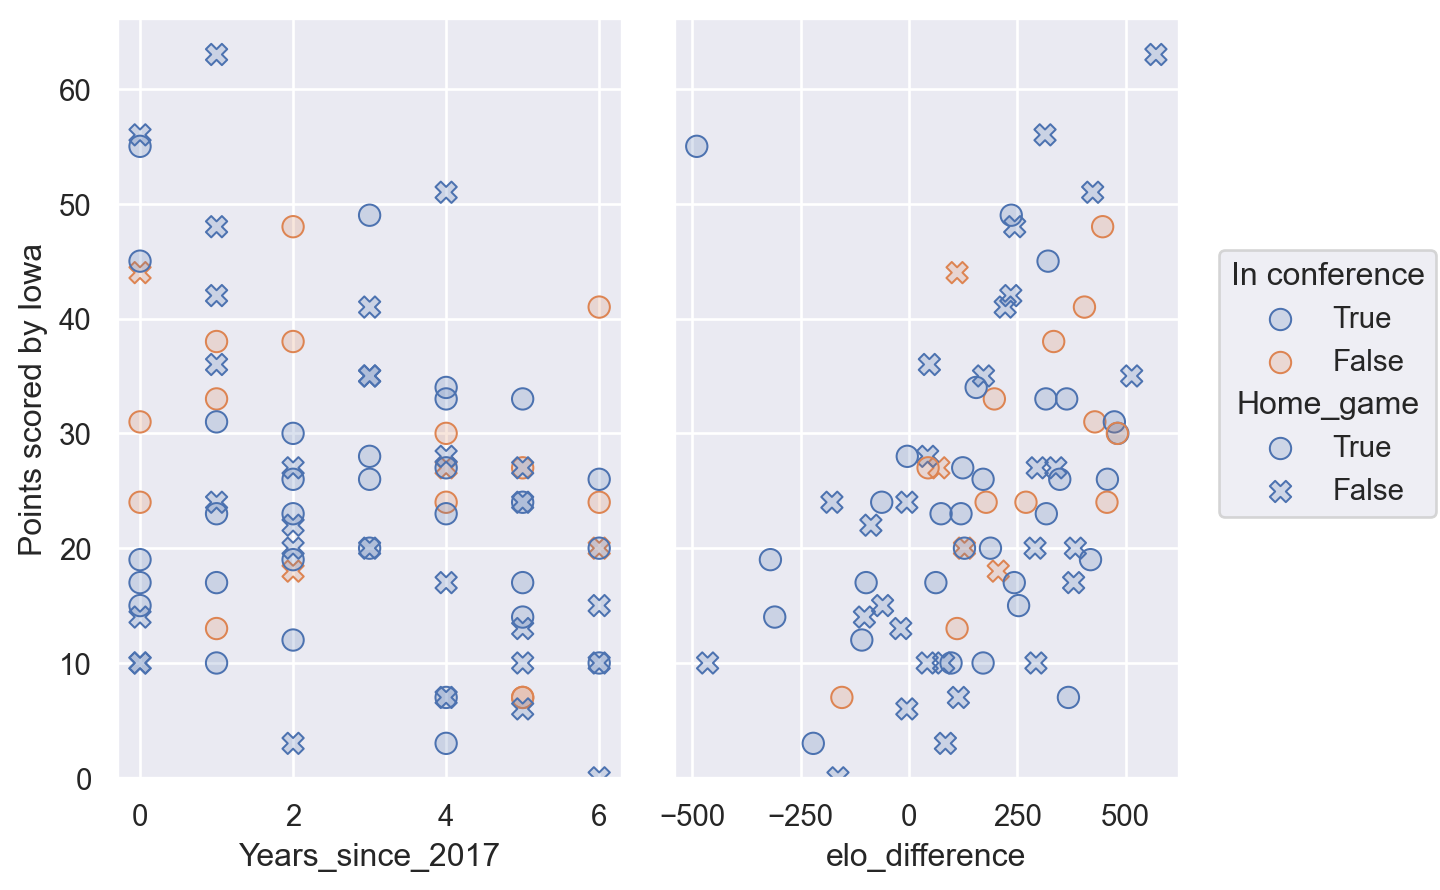

In [6]:
(
    so.Plot(games, y="Iowa_points", color="conference_game", marker="Home_game")
    .pair(x=["Years_since_2017", "elo_difference"])
    .add(so.Dots(pointsize=8))
    # .scale(y="log")
    .limit(y=(0, None))
    .label(y="Points scored by Iowa", color="In conference")
)

# Bayesian mixed-effects model

Let's predict scoring, then, using some mixed effects

We can modify [this pymc tutorial](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-poisson-regression.html) and [this one](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-negative-binomial-regression.html) for the analysis.


In [7]:
design_matrix = design_matrices(
    "Iowa_points ~ conference_game * Years_since_2017 + elo_difference",
    games,
)
exogenous = design_matrix.common.as_dataframe()
endogenous = design_matrix.response.as_dataframe()

Automatically removing 5/81 rows from the dataset.


Now, a few design choices:

1. We're treating this as a [Negative Binomial model](https://library.virginia.edu/data/articles/getting-started-with-negative-binomial-regression-modeling). This is not the most standard distribution to use, but [some guy in 1973](https://www.researchgate.net/publication/254284432_Collegiate_Football_Scores_and_the_Negative_Binomial_Distribution) said it was a good one. We started with a [Poisson regression](https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/generalized_linear_models/GLM-poisson-regression.html), but in a Poisson regression, the mean and variance are equal, and football is a bit weirder than that. Weirder means larger variances.
2. This model is very simple. Two switches for whether it's a home game and a conference game, and an interaction term between those switches. We're depending on capturing and propagating the uncertainty rather than building the most sophisticated (but possibly fragile) model.
3. We're going to break the steps up into
   1. prior checks, then
   2. running on the data, then
   3. checking the posterior distribution, then
   4. finding the true average of Iowa scoring
   5. finding the likelihood of Brian staying

This breakdown hopefully flows well, and 1 and 3 help us have a little confidence that we're not fooling ourselves with ridiculous prior parameter expectations or posterior predictions.


In [8]:
bx_sigma = 0.1

with pm.Model() as model:
    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=np.log(26), sigma=0.1)
    b1 = pm.Normal("conference_game", mu=0, sigma=bx_sigma)
    b2 = pm.Normal("Years_since_2017", mu=0, sigma=bx_sigma)
    b3 = pm.Normal("elo_difference", mu=0, sigma=bx_sigma / 200)
    b4 = pm.Normal("conference_game:Years_since_2017", mu=0, sigma=bx_sigma)

    alpha = pm.Exponential("Alpha_Intercept", 0.5)

    # define linear model and link function
    theta = (
        b0
        + b1 * exogenous["conference_game"].values
        + b2 * exogenous["Years_since_2017"].values
        + b3 * exogenous["elo_difference"].values
        + b4 * exogenous["conference_game:Years_since_2017"].values
    )

    # Define Poisson likelihood
    y = pm.NegativeBinomial(
        "y",
        alpha=alpha,
        mu=pm.math.exp(theta),
        observed=endogenous["Iowa_points"].values,
    )

    idata = pm.sample_prior_predictive(samples=1000, random_seed=rng)

Sampling: [Alpha_Intercept, Intercept, Years_since_2017, conference_game, conference_game:Years_since_2017, elo_difference, y]


Okay, some prior predictive checks to make sure our score distribution doesn't look _too_ outrageous and the difference between home and away games is on the order of 3 points, which is what I've been told Vegas handicappers use.


[Text(0.5, 0, 'Elo difference'), Text(0, 0.5, 'Mean Score'), (0.0, 90.0)]

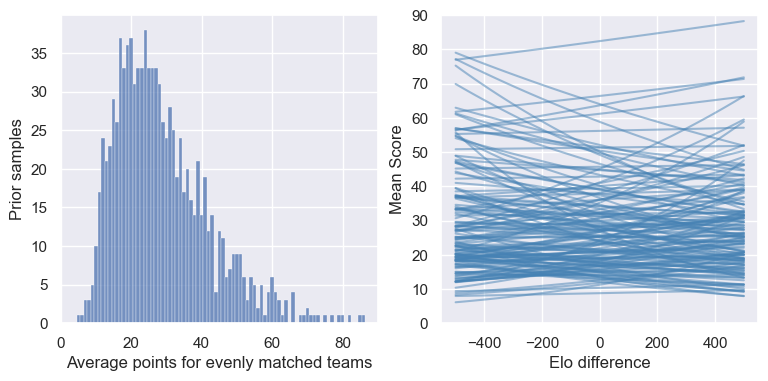

In [9]:
LIM_POINTS = 90

x = xr.DataArray(np.linspace(-500, 500, 100), dims=["plot_dim"])
prior = idata.prior

y = np.exp(
    prior["Intercept"]
    + prior["elo_difference"] * x
    + 0.75 * prior["conference_game"]  # 9/12 games are in conference
    + 0.75
    * prior["conference_game:Years_since_2017"]
    * 6  # interaction between year (2023) and conference game
)
data = y.stack(sample=("chain", "draw")).to_pandas().T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(
    data[50], binrange=(0, LIM_POINTS), discrete=True, multiple="stack", ax=ax1
)
ax1.set(
    xlabel="Average points for evenly matched teams",
    ylabel="Prior samples",
    xlim=(0, LIM_POINTS),
)
ax2.plot(x, data.sample(150).to_numpy().T, c="steelblue", alpha=0.5)
ax2.set(xlabel="Elo difference", ylabel="Mean Score", ylim=(0, LIM_POINTS))

Given that that's an okay set of distributions, let's do the MCMC. You would expect _most_ teams to average between 20 and 40 points per game over a long enough time period.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, conference_game, Years_since_2017, elo_difference, conference_game:Years_since_2017, Alpha_Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


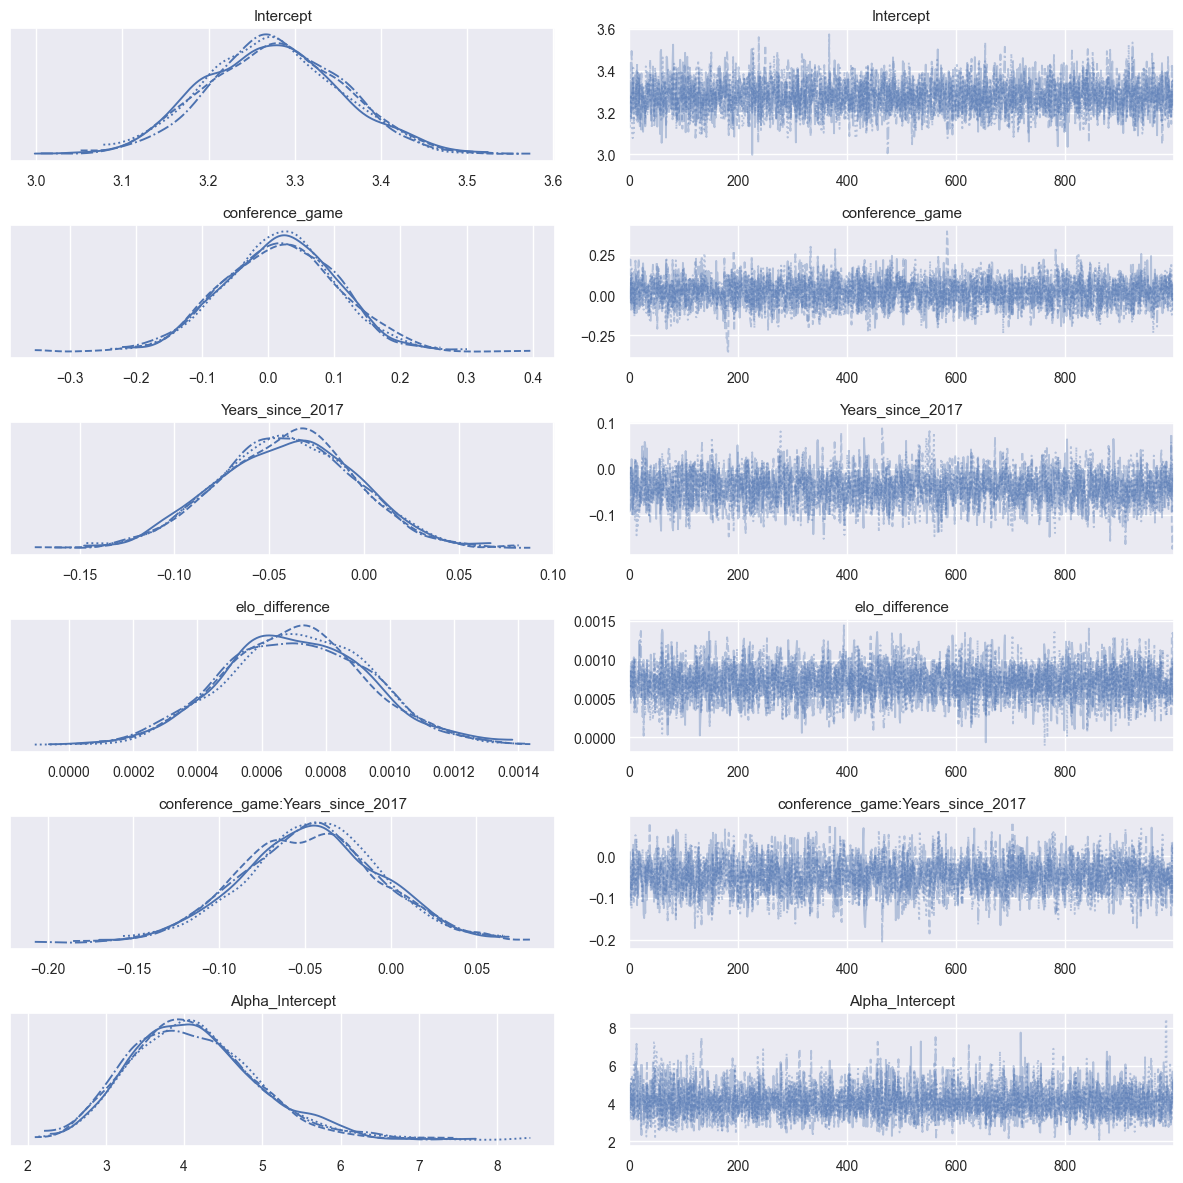

In [10]:
with model:
    idata.extend(pm.sample())
az.plot_trace(idata)
plt.tight_layout()

Elo difference definitely matters, being a conference game definitely does not (after accounting for Elo), the season might interacting with whether it's a conference game might, and the season without interacting with whether it's a conference game might not. Interesting!


Sampling: [y]


[Text(0.5, 0, 'Elo difference'), Text(0, 0.5, 'Mean Score'), (0.0, 90.0)]

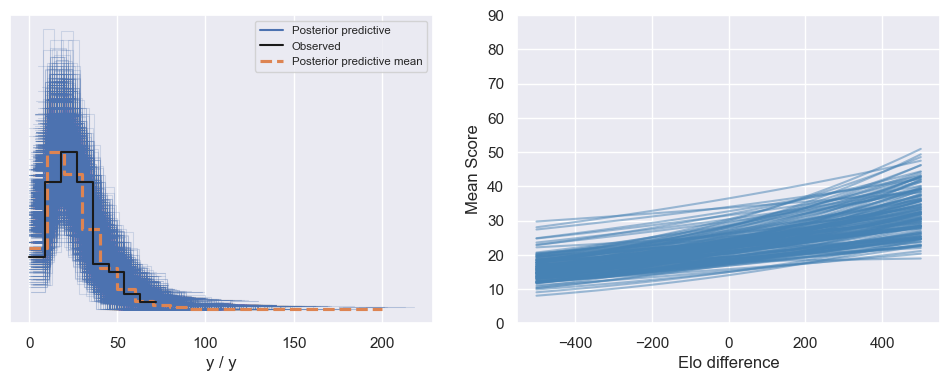

In [11]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
az.plot_ppc(idata, ax=ax1)


posterior = idata.posterior
x = xr.DataArray(np.linspace(-500, 500, 100), dims=["plot_dim"])
y = np.exp(
    posterior["Intercept"]
    + posterior["elo_difference"] * x
    + 0.75 * posterior["conference_game"]  # 9/12 games are in conference
    + 0.75
    * posterior["conference_game:Years_since_2017"]
    * 6  # interaction between year (2023) and conference game
)
data = y.stack(sample=("chain", "draw")).to_pandas().T

ax2.plot(x, data.sample(150).to_numpy().T, c="steelblue", alpha=0.5)
ax2.set(xlabel="Elo difference", ylabel="Mean Score", ylim=(0, LIM_POINTS))

Looks like the posterior predictions follow about the same distribution as the observations, so we're on to the analysis! But let's watch that fat tail with at least a 1/4000 chance of Iowa scoring over 100 points.


Okay, back in cartesian space, what's the average scoring?


In [12]:
elo_difference_average = games.elo_difference.mean()
pd.concat(
    {
        "All-time": az.summary(
            np.exp(
                idata.posterior["Intercept"]
                + idata.posterior["elo_difference"] * games.elo_difference.mean()
            ),
            kind="stats",
        ),
        "All conference": az.summary(
            np.exp(
                idata.posterior["Intercept"]
                + idata.posterior["conference_game"]
                + idata.posterior["elo_difference"]
                * games.loc[games.conference_game, "elo_difference"].mean()
            ),
            kind="stats",
        ),
        "2023": az.summary(
            np.exp(
                idata.posterior["Intercept"]
                + 6 * idata.posterior["Years_since_2017"]
                + idata.posterior["elo_difference"]
                * games.loc[games.season == 2023, "elo_difference"].mean()
            ),
            kind="stats",
        ),
        "2023 conference": az.summary(
            np.exp(
                idata.posterior["Intercept"]
                + 6 * idata.posterior["Years_since_2017"]
                + 6 * idata.posterior["conference_game:Years_since_2017"]
                + idata.posterior["conference_game"]
                + idata.posterior["elo_difference"]
                * games.loc[
                    (games.season == 2023) & (games.conference_game), "elo_difference"
                ].mean()
            ),
            kind="stats",
        ),
    }
).reset_index(level=1, drop=True)

,mean,sd,hdi_3%,hdi_97%
All-time,29.701,2.400,25.459,34.315
All conference,29.871,2.785,24.788,35.235
2023,23.481,4.614,15.192,31.832
2023 conference,17.460,2.313,13.298,21.788


So, all in all, you would expect Iowa to score about 29 points per game against their average opponent, with about a 94% chance their average is between 25 and 34.

In conference in 2023? Somewhere between 14 and 23.

Now, given that we're 6 years after 2017, the number of games left (including the bowl), these being conference games, and the expected Elo ratings for the opponents, what is the chance of Brian getting to stay?

First, he's got to score how much to stay?


In [13]:
points_to_stay = 325
games_left = sum(games["completed"] == False) + 1
points_scored_in_2023 = games.loc[games.season == 2023, "Iowa_points"].sum()
points_per_game_to_stay = (points_to_stay - points_scored_in_2023) / games_left
print(f"Score {points_per_game_to_stay:.2f} to stay")

Score 39.75 to stay


Uh oh, that's outside of our 94% confidence interval.


In [14]:
p = idata.posterior

posterior_2023_points = np.exp(
    (
        p["Intercept"]
        + p["conference_game"] * 0.75
        + p["Years_since_2017"] * 6
        + p["conference_game:Years_since_2017"] * 6 * 0.75
        + p["elo_difference"]
        * games.loc[
            (games.season == 2023) & (games.conference_game), "elo_difference"
        ].mean()
    ).data.ravel()
)
# plt.hist(posterior_2023_points, bins=np.arange(15, 35), cumulative=True, align="left")
# np.percentile(posterior_2023_points, 90)

print(
    f"Chance Iowa's 2023 true scoring average is at or above 25 points per game: {np.mean(posterior_2023_points >= 25):.2%}"
)
print(
    f"Chance of Iowa having a true average scoring potential high enough: {np.mean(posterior_2023_points >= points_per_game_to_stay):.2%}",
)

Chance Iowa's 2023 true scoring average is at or above 25 points per game: 0.60%
Chance of Iowa having a true average scoring potential high enough: 0.00%


That's not good. Let's make a plot to look at the distribution


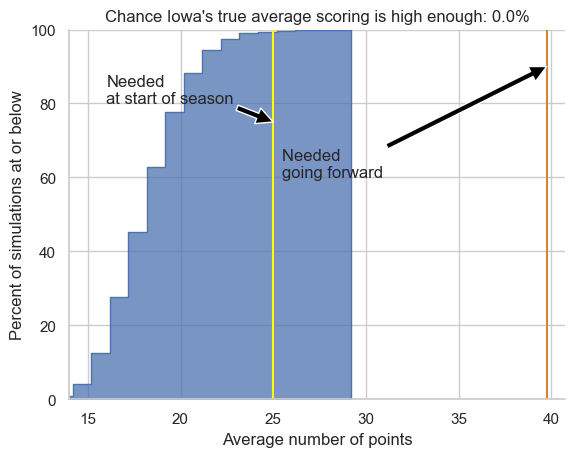

In [15]:
with sns.axes_style("whitegrid"):
    g = sns.histplot(
        posterior_2023_points,
        discrete=True,
        element="step",
        stat="percent",
        cumulative=True,
        fill=True,
    )
    g.set(
        xlim=(14, max([30, points_per_game_to_stay + 1])),
        ylim=(0, 100),
        ylabel="Percent of simulations at or below",
        xlabel="Average number of points",
        title=f"Chance Iowa's true average scoring is high enough: {np.mean(posterior_2023_points >= points_per_game_to_stay):.1%}",
    )
    g.vlines(points_per_game_to_stay, 0, 100, color="peru")
    g.vlines(25, 0, 100, color="yellow")
    sns.despine()
    g.annotate(
        "Needed \ngoing forward",
        xy=(points_per_game_to_stay, 90),
        xytext=(25.5, 60),
        arrowprops=dict(facecolor="black"),
    )
    g.annotate(
        "Needed\nat start of season",
        xy=(25, 75),
        xytext=(16, 80),
        arrowprops=dict(facecolor="black"),
    )

[(12.0, 28.0),
 Text(0, 0.5, 'Percent of simulations'),
 Text(0.5, 0, 'Average number of points Iowa scores')]

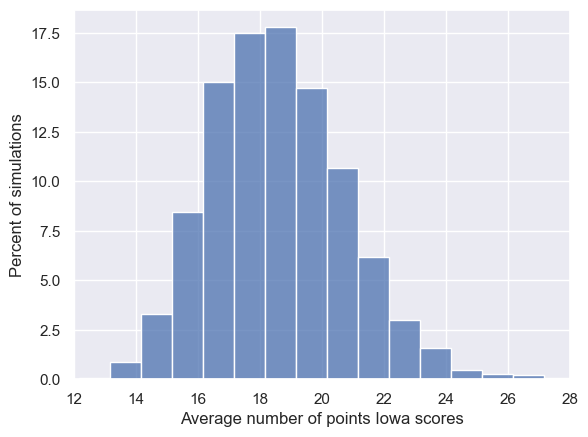

In [16]:
g = sns.histplot(
    posterior_2023_points,
    discrete=True,
    stat="percent",
    fill=True,
)
g.set(
    xlim=(12, 28),
    # ylim=(0, 100),
    ylabel="Percent of simulations",
    xlabel="Average number of points Iowa scores",
)

Okay, that's the average number of points over abour 4,000 virtual Iowa seasons. But what's the distribution of points that could be scored _this_ season?

Let's create a bunch of posterior predicted scores and sample from them. First, break things into home and away games, then draw from the Negative Binomial distribution given by the posterior for these "simulated" games.


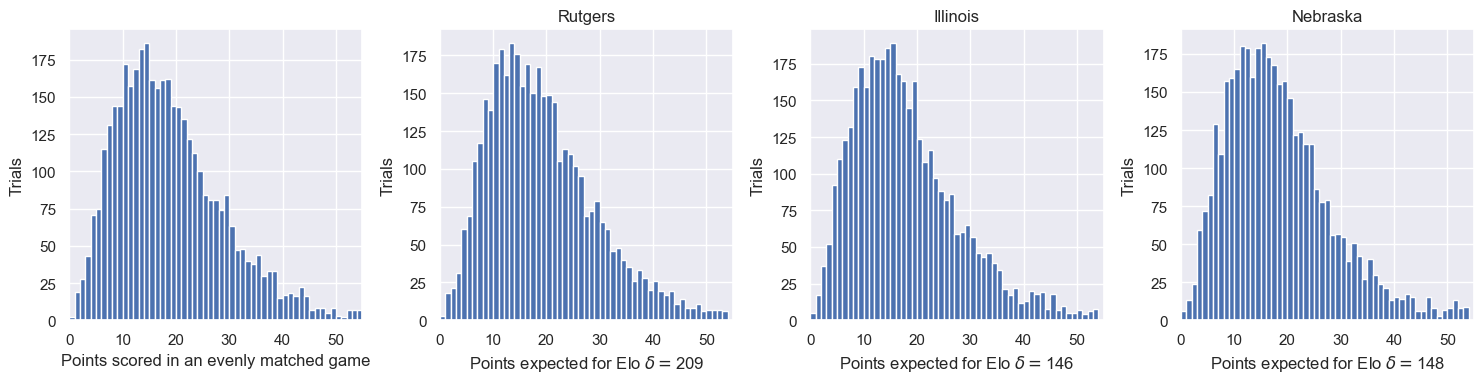

In [17]:
p = idata.posterior

alpha = p["Alpha_Intercept"].data.ravel()


def neg_binom_p(mu, alpha):
    """Calculate p to switch from the PyMC parameterization to the numpy one.

    See <https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.NegativeBinomial.html>
    """
    return alpha / (mu + alpha)


# And another sampling:
points_distributed = rng.negative_binomial(
    p=neg_binom_p(posterior_2023_points, alpha), n=alpha
)

posterior_upcoming_schedule = np.exp(
    (
        p["Intercept"]
        + p["conference_game"]
        + p["Years_since_2017"] * 6
        + p["conference_game:Years_since_2017"] * 6
        + p["elo_difference"]
        * rng.choice(
            games.loc[(games.season == 2023) & ~games["completed"], "elo_difference"],
            size=p["elo_difference"].shape,
        )
    ).data.ravel()
)

points_distributed_upcoming = rng.negative_binomial(
    p=neg_binom_p(posterior_upcoming_schedule, alpha), n=alpha
)

upcoming_games = games.loc[(games.season == 2023) & ~games["completed"]]

fig, axes = plt.subplots(1, 1 + upcoming_games.shape[0], figsize=(15, 4))
axes[0].hist(
    points_distributed,
    bins=np.arange(0, 56, 1),
    histtype="barstacked",
)
axes[0].set(
    xlim=(0, 55), xlabel="Points scored in an evenly matched game", ylabel="Trials"
)

i_hist = 1
for _, game in upcoming_games.iterrows():
    posterior_upcoming_team = np.exp(
        (
            p["Intercept"]
            + p["conference_game"]
            + p["Years_since_2017"] * 6
            + p["conference_game:Years_since_2017"] * 6
            + p["elo_difference"] * game["elo_difference"]
        ).data.ravel()
    )

    points_distributed_upcoming_team = rng.negative_binomial(
        p=neg_binom_p(posterior_upcoming_team, alpha), n=alpha
    )

    axes[i_hist].hist(
        points_distributed_upcoming_team,
        bins=np.arange(0, 55, 1),
    )
    axes[i_hist].set(
        xlim=(0, 55),
        xlabel=f"Points expected for Elo $\delta=${game['elo_difference']:.0f}",
        ylabel="Trials",
        title=game["Opponent"],
    )
    i_hist += 1
fig.tight_layout()

Okay, that distribution looks a little more right-shifted than I would expect (though a huge improvement over the Poisson model), considering the recent PSU game with an offensive output of 0 points. We'll let it stand because we know about the interaction with Elo.


In [18]:
def max_bin_percent(points):
    """Get the height of the highest histogram bin in %."""
    hist_points = np.histogram(points, bins=np.arange(min(points), max(points) + 1))[0]
    max_bin = max(hist_points)
    return max_bin / sum(hist_points) * 100

Chance we'll see Brian next year: 0.00%


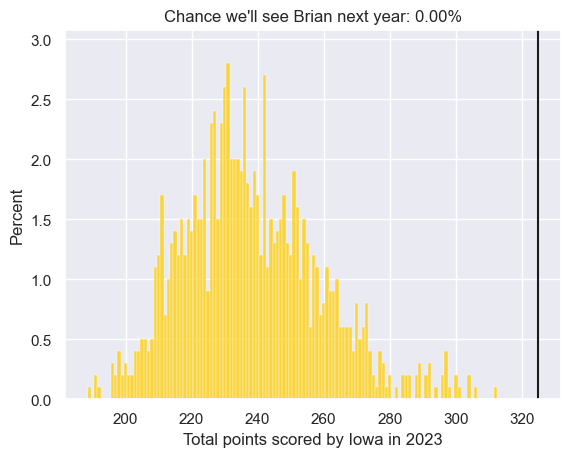

In [19]:
NUM_TRIALS = 1000
points_distributed_total = points_scored_in_2023 + np.sum(
    rng.choice(points_distributed_upcoming, size=(NUM_TRIALS, games_left)), axis=-1
)

likelihood_brian_stays = np.mean(points_distributed_total >= 325)

vline_max = max_bin_percent(points_distributed_total) * 1.1
g = sns.histplot(
    points_distributed_total, stat="percent", discrete=True, color="#FFCD00"
)
g.vlines(325, 0, vline_max, color="k")
title_text = f"Chance we'll see Brian next year: {likelihood_brian_stays:.2%}"
g.set(
    xlabel="Total points scored by Iowa in 2023",
    ylim=(0, vline_max),
    title=title_text,
)
print(title_text)

So you say there's no chance
